In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from plot_utils import plotCategoricalPerformance
from efn_util import get_flowdict, get_flowstring, get_ef_dimensionalities
import os
import seaborn as sns
import pandas as pd

matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)


In [2]:

exp_fam = 'normal';
model_info = {'subclass':'EFN', 'extrastr':''};

datadir = '/Users/sbittner/Documents/efn/results/Fig3/';
max_iters = 50000;
if (exp_fam == 'dirichlet'):
    Ds = [3, 5, 10, 15, 20, 25, 50];
    give_inverse_hint = False;
    scatterR2ylim = [.8, 1];
    errovbarR2ylim = scatterR2ylim;
    scatterKLylim = [0, 0.5];
    errorbarKLylim = scatterKLylim;
elif (exp_fam == 'normal' or exp_fam == 'normal5'):
    Ds = [2, 5, 10, 15, 20, 25, 40];
    give_inverse_hint = True;
    scatterR2ylim = [.8, 1];
    errorbarR2ylim = scatterR2ylim;
    scatterKLylim = [0, .5];
    errorbarKLylim = scatterKLylim;
elif (exp_fam == 'inv_wishart'):
    Ds = [4, 9, 16];
    give_inverse_hint = True;
    scatterR2ylim = [0, 1];
    errorbarR2ylim = scatterR2ylim;
    scatterKLylim = [0, 10];
    errorbarKLylim = scatterKLylim;
elif (exp_fam == 'prp_tn'):
    Ds = [2, 5, 10, 15, 20];
    give_inverse_hint = True;
    scatterR2ylim = [0, 1];
    errorbarR2ylim = scatterR2ylim;
    scatterKLylim = [0, 10];
    errorbarKLylim = scatterKLylim;
elif (exp_fam == 'dir_dir'):
    Ds = [5, 10, 15, 20];
    give_inverse_hint = True;
    scatterR2ylim = [0, 1];
    errorbarR2ylim = scatterR2ylim;
    scatterKLylim = [0, 10];
    errorbarKLylim = scatterKLylim;
    
num_Ds = len(Ds);

if (give_inverse_hint):
    give_inv_str = 'giveInv_';
else:
    give_inv_str = '';
        
num_rs = 10;
K = 100;
M = 1000;

EFN_R2s = np.zeros((num_Ds, K));
EFN_KLs = np.zeros((num_Ds, K));
NF1_R2s = np.zeros((num_Ds, num_rs));
NF1_KLs = np.zeros((num_Ds, num_rs));
EFN1_R2s = np.zeros((num_Ds, num_rs));
EFN1_KLs = np.zeros((num_Ds, num_rs));

def report_model_status(fname, R2nz, KLnz, R2nans, KLnans, file_exists):
    if (not file_exists):
        return 1;
    elif (R2nz > 0 or KLnz > 0):
        return 2;
    elif (R2nans > 0 or KLnans > 0):
        return 3;
    return 4
    
def get_R2_KL(fname, max_iters):
    file_exists = False;
    if (not os.path.isfile(fname)):
        R2vals = np.nan;
        KLvals = np.nan;
    else:
        file_exists = True;
        X = np.load(fname);
        check_rate = X['check_rate'];
        R2s = X['test_R2s'];
        KLs = X['test_KLs'];
        num_checks = R2s.shape[0];
        nits = check_rate*num_checks;
        opt_ind = int((max_iters/nits)*num_checks)-1;
        K = X['train_R2s'].shape[1];
        R2vals = X['train_R2s'][opt_ind,:];
        KLvals = X['train_KLs'][opt_ind,:];
    R2nz_orig = np.sum(R2vals == 0);
    KLnz_orig = np.sum(KLvals == 0);
    R2nans = np.sum(np.isnan(R2vals));
    KLnans = np.sum(np.isnan(KLvals));
    if (R2nz_orig == K and KLnz_orig == K):
        print(fname);
        print('looking back in time for latest R2 or KL');
        found = False;
        dec = 1;
        while (not found):
            R2vals = X['train_R2s'][opt_ind-dec,:];
            KLvals = X['train_KLs'][opt_ind-dec,:];
            R2nz = np.sum(R2vals == 0);
            KLnz = np.sum(KLvals == 0);
            found = not (R2nz == K and KLnz == K);
            dec = dec+1;
        print('found it at %d' % int((opt_ind-(dec+1))*check_rate));
        
        
    #print(R2nz, KLnz, R2nans, KLnans);
    if (R2nz_orig > 0 or KLnz_orig > 0 or R2nans > 0 or KLnans > 0):
        status = report_model_status(fname, R2nz_orig, KLnz_orig, R2nans, KLnans, file_exists);
    else:
        status = 0;
    return R2vals, KLvals, status;

def log_fname(fname, status, status_lists):
    if status != 0:
        status_lists[status-1].append(fname);

not_started = [];
in_progress = [];
unstable = [];
status_lists = [not_started, in_progress, unstable];

for i in range(num_Ds):
    D = Ds[i];
    if (exp_fam == 'normal5'):
        exp_fam_str = 'normal';
    else:
        exp_fam_str = exp_fam;
    D_Z, ncons, num_param_net_inputs, num_Tx_inputs = get_ef_dimensionalities(exp_fam_str, D, model_info, give_inverse_hint);
    #planar_flows = D;
    planar_flows = max(D, 20);
    flow_dict = get_flowdict(0, planar_flows, 0, 0);
    flowstring = get_flowstring(flow_dict);
    
    #L = int(np.ceil(np.sqrt(D_Z)));
    L = max(int(np.ceil(np.sqrt(D_Z))), 4);
    efn_fname = datadir + 'EFN_%s_stochasticEta_%sD=%d_K=%d_M=%d_flow=%s_L=%d_rs=%d/results.npz' \
                           % (exp_fam, give_inv_str, D, K, M, flowstring, L, 0);
    EFN_R2s[i,:], EFN_KLs[i,:], status = get_R2_KL(efn_fname, max_iters);
    
    log_fname(efn_fname, status, status_lists);
    
    for rs in range(num_rs):
        nf1_fname = datadir + 'NF1/NF1_%s_D=%d_flow=%s_rs=%d/results.npz' % (exp_fam, D, flowstring, rs+1);
        NF1_R2s[i,rs], NF1_KLs[i,rs], status_nf1 = get_R2_KL(nf1_fname, max_iters);
        log_fname(nf1_fname, status_nf1, status_lists);
        
        if (exp_fam == 'dirichlet' and D==25): # sometimes opt broke down.  Ran some extra
            if (rs == 1):
                rs_ind = 14;
            elif (rs == 3):
                rs_ind = 11;
            elif (rs == 7):
                rs_ind = 12;
            else:
                rs_ind = rs + 1;
        elif (exp_fam == 'dirichlet' and D==50):
            rs_ind = rs+1;
        else:
            rs_ind = rs + 1;
        efn1_fname = datadir + 'EFN1/EFN_%s_fixedEta_%sD=%d_K=%d_M=%d_flow=%s_L=%d_rs=%d/results.npz' \
                           % (exp_fam, give_inv_str, D, 1, M, flowstring, L, rs_ind);
        EFN1_R2s[i,rs], EFN1_KLs[i,rs], status_efn1 = get_R2_KL(efn1_fname, max_iters);
        log_fname(efn1_fname, status_efn1, status_lists);


In [3]:
text_start_ind = 43;
print("Haven't started:");
for fname in not_started:
    print(fname[text_start_ind:]);
print('\n');
    
print("Still running:");
for fname in in_progress:
    print(fname[text_start_ind:]);  
print('\n');

print('Unstable:');
for fname in unstable:
    print(fname[text_start_ind:]);
print('\n');


Haven't started:


Still running:


Unstable:




/Users/sbittner/Library/Python/3.6/lib/python/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


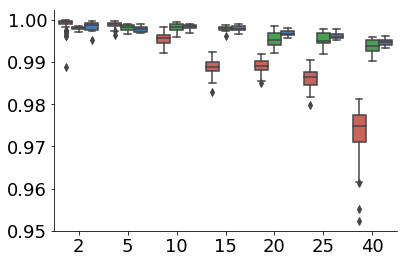

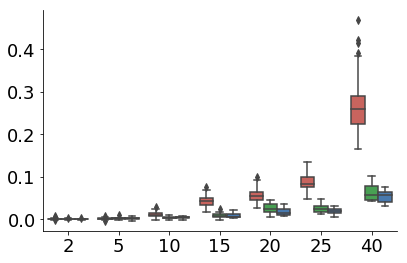

In [4]:
colors = ["pale red", "medium green", "windows blue", "amber", "dusty purple", "greyish", "faded green", "denim blue"];

palette = sns.xkcd_palette(colors)
EFN_R2s_vec = np.reshape(EFN_R2s.T, (np.prod(EFN_R2s.shape),));
NF1_R2s_vec = np.reshape(NF1_R2s.T, (np.prod(NF1_R2s.shape),));
EFN1_R2s_vec = np.reshape(EFN1_R2s.T, (np.prod(EFN1_R2s.shape),));

EFN_KLs_vec = np.reshape(EFN_KLs.T, (np.prod(EFN_KLs.shape),));
NF1_KLs_vec = np.reshape(NF1_KLs.T, (np.prod(NF1_KLs.shape),));
EFN1_KLs_vec = np.reshape(EFN1_KLs.T, (np.prod(EFN1_KLs.shape),));

EFN_remove_inds = np.logical_or(np.isnan(EFN_R2s_vec), np.logical_or(np.isnan(EFN_KLs_vec), (EFN_R2s_vec < 0)));
NF1_remove_inds = np.logical_or(np.isnan(NF1_R2s_vec), np.logical_or(np.isnan(NF1_KLs_vec), (NF1_R2s_vec < 0)));
EFN1_remove_inds = np.logical_or(np.isnan(EFN1_R2s_vec), np.logical_or(np.isnan(EFN1_KLs_vec), (EFN1_R2s_vec < 0)));

EFN_Ds_mat = np.tile(np.expand_dims(np.array(Ds), 1), (1, EFN_R2s.shape[1]));
EFN_Ds_vec = np.reshape(EFN_Ds_mat.T, (np.prod(EFN_Ds_mat.shape),));
NF1_Ds_mat = np.tile(np.expand_dims(np.array(Ds), 1), (1, NF1_R2s.shape[1]));
NF1_Ds_vec = np.reshape(NF1_Ds_mat.T, (np.prod(NF1_Ds_mat.shape),));
EFN1_Ds_mat = np.tile(np.expand_dims(np.array(Ds), 1), (1, EFN1_R2s.shape[1]));
EFN1_Ds_vec = np.reshape(EFN1_Ds_mat.T, (np.prod(EFN1_Ds_mat.shape),));

EFN_R2s_vec = EFN_R2s_vec[~EFN_remove_inds];
NF1_R2s_vec = NF1_R2s_vec[~NF1_remove_inds];
EFN1_R2s_vec = EFN1_R2s_vec[~EFN1_remove_inds];

EFN_KLs_vec = EFN_KLs_vec[~EFN_remove_inds];
NF1_KLs_vec = NF1_KLs_vec[~NF1_remove_inds];
EFN1_KLs_vec = EFN1_KLs_vec[~EFN1_remove_inds];

EFN_Ds_vec = EFN_Ds_vec[~EFN_remove_inds];
NF1_Ds_vec = NF1_Ds_vec[~NF1_remove_inds];
EFN1_Ds_vec = EFN1_Ds_vec[~EFN1_remove_inds];

R2s_vec = np.concatenate((EFN_R2s_vec, NF1_R2s_vec, EFN1_R2s_vec), axis=0);
KLs_vec = np.concatenate((EFN_KLs_vec, NF1_KLs_vec, EFN1_KLs_vec), axis=0);
Ds_vec = np.concatenate((EFN_Ds_vec, NF1_Ds_vec, EFN1_Ds_vec), axis=0);

model_strs = EFN_R2s_vec.shape[0]*['EFN'];
model_strs.extend(NF1_R2s_vec.shape[0]*['NF1']);
model_strs.extend(EFN1_R2s_vec.shape[0]*['EFN1']);

d = {"R2":R2s_vec, "KL":KLs_vec, "D":Ds_vec, "model":model_strs};
df = pd.DataFrame.from_dict(d);
plt.figure(figsize=(6,4));
ax = sns.boxplot(x='D', y='R2', hue='model', \
                      data=df, palette=palette)
if (not (exp_fam == 'dirichlet')):
    ax.legend_.remove();
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('')
plt.tight_layout();
plt.savefig('/Users/sbittner/Documents/efn/written/figs/fig3/%s_R2.pdf' % exp_fam, \
            dpi=300, transparent=True)
plt.show();

plt.figure(figsize=(6,4));
ax = sns.boxplot(x='D', y='KL', hue='model',
                      data=df, palette=palette)
ax.legend_.remove()
ax.set_xlabel('')
ax.set_ylabel('')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout();
plt.savefig('/Users/sbittner/Documents/efn/written/figs/fig3/%s_KL.pdf' % exp_fam, \
            dpi=300, transparent=True)
plt.show();

/Users/sbittner/Library/Python/3.6/lib/python/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


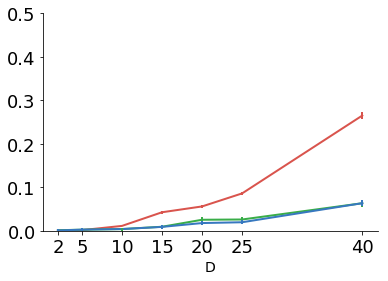

In [41]:
plottype = 'errorBar';
fontsize = 14;
dotsize = 20;
x = np.array(Ds);
"""
fig = plt.figure(figsize=(12, 4));
ax = fig.add_subplot(1,2,1);
y = [EFN_R2s, NF1_R2s, EFN1_R2s];
plotCategoricalPerformance(x, y, legendstrs, plottype=plottype, \
                           dotsize=dotsize, shift=.25);
ax.set_xticks(x);
ax.set_xticklabels(Ds);
plt.xlabel('D', fontsize=fontsize);
plt.ylabel('R2', fontsize=fontsize);
if (plottype=='scatter'):
    plt.ylim(scatterR2ylim);
elif (plottype=='errorBar'):
    plt.ylim(errorbarR2ylim);    
"""

fontsize = 14;
dotsize = 20;
x = np.array(Ds);
if (exp_fam == 'dirichlet'):
    legendstrs = ['EFN', 'NF1', 'EFN1'];
else:
    legendstrs = [];
    
#ax = fig.add_subplot(1,2,2);
plt.figure();
y = [EFN_KLs, NF1_KLs, EFN1_KLs];
plotCategoricalPerformance(x, y, legendstrs, plottype=plottype, \
                           dotsize=dotsize, shift=.5);
ax = plt.gca();
ax.set_xticks(x);
ax.set_xticklabels(Ds);
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('D', fontsize=fontsize);
if (exp_fam == 'dirichlet'):
    plt.ylabel('KL', fontsize=fontsize);
if (plottype=='scatter'):
    plt.ylim(scatterKLylim);
elif (plottype=='errorBar'):
    plt.ylim(errorbarKLylim);
plt.show();

/Users/sbittner/Library/Python/3.6/lib/python/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


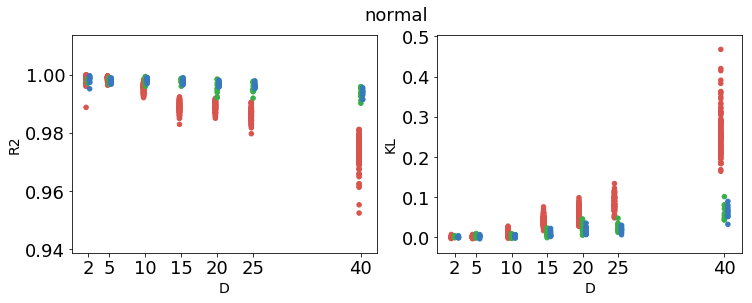

In [42]:
plottype = 'scatter';
fontsize = 14;
dotsize = 20;
x = np.array(Ds);
legendstrs = ['EFN', 'NF1', 'EFN1'];
fig = plt.figure(figsize=(12, 4));
ax = fig.add_subplot(1,2,1);
y = [EFN_R2s, NF1_R2s, EFN1_R2s];
plotCategoricalPerformance(x, y, [], plottype=plottype, \
                           dotsize=dotsize, shift=.25);
ax.set_xticks(x);
ax.set_xticklabels(Ds);
plt.xlabel('D', fontsize=fontsize);
plt.ylabel('R2', fontsize=fontsize);
#if (plottype=='scatter'):
#    plt.ylim(scatterR2ylim);
#elif (plottype=='errorBar'):
#    plt.ylim(errorbarR2ylim);

fontsize = 14;
dotsize = 20;
x = np.array(Ds);
ax = fig.add_subplot(1,2,2);
y = [EFN_KLs, NF1_KLs, EFN1_KLs];
plotCategoricalPerformance(x, y, [], plottype=plottype, \
                           dotsize=dotsize, shift=.5);
ax.set_xticks(x);
ax.set_xticklabels(Ds);
plt.xlabel('D', fontsize=fontsize);
plt.ylabel('KL', fontsize=fontsize);
#if (plottype=='scatter'):
#    plt.ylim(scatterKLylim);
#elif (plottype=='errorBar'):
#   plt.ylim(errorbarKLylim);
plt.suptitle(exp_fam, fontsize=fontsize+4);
plt.show();